# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Инструкция по выполнению проекта
Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.
- Загрузите и подготовьте данные.
- Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
- Проанализируйте скорость работы и качество моделей.

Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del: del features_train 

### Описание данных
Данные находятся в файле /datasets/autos.csv. 
Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [2]:
# подключаем необходимые библиотеки
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor

from sklearn.dummy import DummyRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OrdinalEncoder

import time

%matplotlib inline

In [3]:
import lightgbm as lgb
import sklearn

import warnings
warnings.filterwarnings("ignore")

print("Версия LightGBM      : ", lgb.__version__)
print("Версия Scikit-Learn  : ", sklearn.__version__)

Версия LightGBM      :  3.2.1
Версия Scikit-Learn  :  0.24.1


In [4]:
#sklearn.metrics.SCORERS.keys()

In [5]:
# читаем данные
local = False
if local:
    df = pd.read_csv('./datasets/autos.csv')
else:
    url = "https://drive.google.com/file/d/148KPjuznebQ8niuiQ0HOFfKVFGaUidez/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    df = pd.read_csv(path)    

In [6]:
#смотрим
df.sample(5, random_state=42)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
294049,2016-03-20 20:54:33,19999,wagon,2014,manual,122,leon,30000,3,petrol,seat,no,2016-03-20 00:00:00,0,22089,2016-03-27 10:47:13
76415,2016-03-25 12:56:02,14250,wagon,2011,manual,140,a3,70000,6,gasoline,audi,NaN,2016-03-25 00:00:00,0,45770,2016-03-29 11:48:26
212563,2016-03-09 13:46:02,2850,wagon,2001,manual,131,passat,150000,9,gasoline,volkswagen,no,2016-03-09 00:00:00,0,38259,2016-03-12 11:16:57
109307,2016-03-30 11:39:47,50,small,1996,manual,60,corsa,150000,8,petrol,opel,yes,2016-03-30 00:00:00,0,7957,2016-04-03 00:46:29
248545,2016-03-28 23:37:54,500,NaN,2016,manual,82,a_klasse,150000,2,petrol,mercedes_benz,NaN,2016-03-28 00:00:00,0,49356,2016-03-30 23:17:28


Переведем названия колонок в нижний регистр - для удобства.

In [6]:
df.columns = df.columns.str.lower()

Посмотри, есть ли явные аномалии.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registrationyear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registrationmonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
numberofpictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postalcode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


**Вывод**: Есть некоторые проблемы с годом и месяцем выпуска автомобиля. Необходимо убрать эти аномалии, так как это очевидно один из самых критических показателей влияющих на формирование цены.

Также сомнительна мощность в 20 000 л.с. Это всё таки не пароход, а автомобиль.

Есть пустая колонка с количеством фото. Необходимо будет убрать.

### Обработка пропусков

Посмотрим на процентное содержание пропусков по колонкам.

In [8]:
df.isna().mean().sort_values(ascending=False)

notrepaired          0.200791
vehicletype          0.105794
fueltype             0.092827
gearbox              0.055967
model                0.055606
datecrawled          0.000000
price                0.000000
registrationyear     0.000000
power                0.000000
kilometer            0.000000
registrationmonth    0.000000
brand                0.000000
datecreated          0.000000
numberofpictures     0.000000
postalcode           0.000000
lastseen             0.000000
dtype: float64

У нас несколько проблемных колонок. Рассмотрим в порядке убывания.

In [9]:
df['notrepaired'].value_counts(normalize=True, dropna=False).sort_values(ascending=False)

no     0.697468
NaN    0.200791
yes    0.101741
Name: notrepaired, dtype: float64

**Вывод**: Больще всегo пропусков (20%) в колонке: NotRepaired — была машина в ремонте или нет. Предположим, что пропуск соответсвует отсутствию ремонта. И заменим пропуск на категорию 'no'.

In [10]:
# убираем пропуск
df['notrepaired'] = df['notrepaired'].fillna('no');

Далее колонки vehicletype, fueltype и gearbox.

In [11]:
df['vehicletype'].value_counts(normalize=True, dropna=False).sort_values(ascending=False)

sedan          0.258084
small          0.225276
wagon          0.183893
NaN            0.105794
bus            0.081201
convertible    0.057011
coupe          0.045611
suv            0.033852
other          0.009278
Name: vehicletype, dtype: float64

In [12]:
df['fueltype'].value_counts(normalize=True, dropna=False).sort_values(ascending=False)

petrol      0.610527
gasoline    0.278580
NaN         0.092827
lpg         0.014984
cng         0.001594
hybrid      0.000658
other       0.000576
electric    0.000254
Name: fueltype, dtype: float64

In [13]:
df['gearbox'].value_counts(normalize=True, dropna=False).sort_values(ascending=False)

manual    0.756982
auto      0.187051
NaN       0.055967
Name: gearbox, dtype: float64

**Вывод:** Содержание пропусков в данных колонках составляет от 5 до 10%. Tип автомобильного кузова (vehicletype), тип топлива (fueltype) и тип коробки передач (gearbox) - являются важнейшими критериями при выборе автомобиля и должны быть обязательно заполнены. Поэтому, для построения корректной модели строки с пропусками в данных колоках мы удалим.

In [14]:
shape_befor = df.shape
df = df.dropna()
shape_after = df.shape
print('Удалено строк {:%}'.format(1 - shape_after[0]/shape_befor[0]))

Удалено строк 19.821993%


In [15]:
# проверяем
df.isna().mean().sort_values(ascending=False)

datecrawled          0.0
price                0.0
vehicletype          0.0
registrationyear     0.0
gearbox              0.0
power                0.0
model                0.0
kilometer            0.0
registrationmonth    0.0
fueltype             0.0
brand                0.0
notrepaired          0.0
datecreated          0.0
numberofpictures     0.0
postalcode           0.0
lastseen             0.0
dtype: float64

In [16]:
# второй вариант с заполнением NaN - если не удалять пропуски, заблокирован.
if False:
    df['vehicletype'] = df['vehicletype'].fillna('nan')
    df['fueltype'] = df['fueltype'].fillna('nan')
    df['gearbox'] = df['gearbox'].fillna('nan')

**Вывод:** Пропуски удалены.

### Преобразование и отбор признаков

Колонки: datecrawle — дата скачивания анкеты из базы, datecrawled — дата создания анкеты, lastseen — дата последней активности пользователя и postalcode — почтовый индекс владельца анкеты (пользователя) -  вряд ли будут полезны для построения моделей предсказания цены. Убираем данные колонки из датасета. Также уберем пустую колонку numberofpictures.

In [17]:
if 'datecrawled' in df.columns:
    df = df.drop(['datecrawled'], axis=1)
if 'datecreated' in df.columns:
    df = df.drop(['datecreated'], axis=1)
if 'lastseen' in df.columns:    
    df = df.drop(['lastseen'], axis=1)
if 'numberofpictures' in df.columns: 
    df = df.drop(['numberofpictures'], axis=1)
# if 'postalcode' in df.columns:
#     df = df.drop(['postalcode'], axis=1)

In [18]:
print(df.shape)

(284126, 12)


Возможно, нам понадобиться преобразовать типы данных. Смотрим общую информацию.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284126 entries, 2 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              284126 non-null  int64 
 1   vehicletype        284126 non-null  object
 2   registrationyear   284126 non-null  int64 
 3   gearbox            284126 non-null  object
 4   power              284126 non-null  int64 
 5   model              284126 non-null  object
 6   kilometer          284126 non-null  int64 
 7   registrationmonth  284126 non-null  int64 
 8   fueltype           284126 non-null  object
 9   brand              284126 non-null  object
 10  notrepaired        284126 non-null  object
 11  postalcode         284126 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 28.2+ MB


Преобразуем object колонки в категориальные, а также некоторые числовые в более простые типы.

In [20]:
df.head(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,postalcode
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,67112


Присмотримся к датам выпуска автомобиля.

In [21]:
len(df['registrationyear'].unique())

88

In [22]:
len(df['registrationmonth'].unique())

13

Text(0.5, 1.0, 'Распределение по годам выпуска')

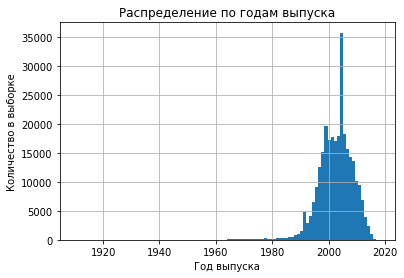

In [23]:
# распределение по годам выпуска
df['registrationyear'].hist(bins = 100)
plt.ylabel('Количество в выборке')
plt.xlabel('Год выпуска')
plt.title('Распределение по годам выпуска')

Год выпуска - явно категориальный признак. Но 88 штук на категорию, слишком много. Добавим ещё один признак, который сделаем по 10 квантилям. (100 лет = 10*10)

In [24]:
bins = 10
list_bins = []

list_bins.append(df['registrationyear'].min())

for i in range(1,bins+1):
    margin = df['registrationyear'].quantile(i*1/bins)
    list_bins.append(margin)

print(list_bins)
print(len(list_bins))

[1910, 1996.0, 1998.0, 2000.0, 2001.0, 2003.0, 2004.0, 2006.0, 2008.0, 2010.0, 2018.0]
11


In [25]:
def yearbin(raw):
    for i in range(1,bins+1):
        if list_bins[i - 1] <= raw['registrationyear'] and raw['registrationyear'] <= list_bins[i]:
            return i
    return -1
df['yearbin'] = df.apply(yearbin, axis=1)

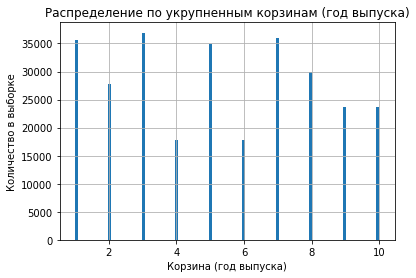

In [26]:
# распределение по годам выпуска по укрупненным корзинам
df['yearbin'].hist(bins = 100)
plt.ylabel('Количество в выборке')
plt.xlabel('Корзина (год выпуска)')
plt.title('Распределение по укрупненным корзинам (год выпуска)');

Всё *registrationyear* более-менее ровно.

Посмотрим на 'registrationmonth', хотя есть мнение, что он вообще не нуже. Так, как на фоне разброса в 100 лет, влияние месяца на цену сомнительно.

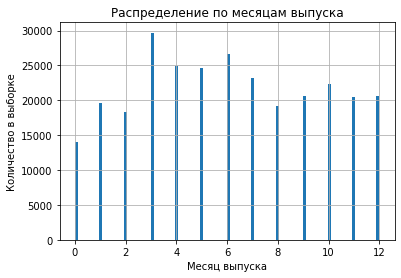

In [27]:
# распределение по месяцам выпуска
df['registrationmonth'].hist(bins = 100)
plt.ylabel('Количество в выборке')
plt.xlabel('Месяц выпуска')
plt.title('Распределение по месяцам выпуска');

Всё *registrationmonth* более-менее ровно.

Попробуем укрупнить почтовый индекс до региона. Возьмем первую цифру индекса.

In [28]:
df['region'] = df.apply(lambda raw: str(raw['postalcode'])[0:1], axis=1)

In [29]:
df['region'].unique()

array(['9', '6', '3', '1', '5', '4', '8', '7', '2'], dtype=object)

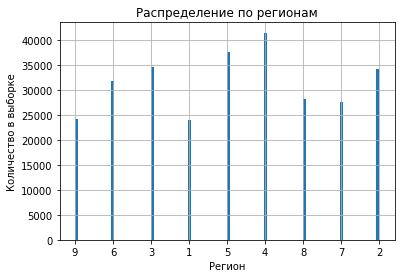

In [30]:
df['region'].hist(bins = 100)
plt.ylabel('Количество в выборке')
plt.xlabel('Регион')
plt.title('Распределение по регионам');

Теперь для *region* более-менее ровно.

Окончательно разберем датасет на категориальные и цифровые признаки. Всё, что не ['price','power','kilometer'] будет категориальным признаком.

In [31]:
def getlist(df):
    # список - цифровые признаки
    digital_features_name = ['price','power','kilometer']

    # список - категориальные признаки
    cat_features_name = [col for col in df.columns if col not in digital_features_name]

    for feature in cat_features_name:
        df[feature] = df[feature].astype('category')
        
    return digital_features_name, cat_features_name

getlist(df)

(['price', 'power', 'kilometer'],
 ['vehicletype',
  'registrationyear',
  'gearbox',
  'model',
  'registrationmonth',
  'fueltype',
  'brand',
  'notrepaired',
  'postalcode',
  'yearbin',
  'region'])

In [32]:
df.dtypes

price                   int64
vehicletype          category
registrationyear     category
gearbox              category
power                   int64
model                category
kilometer               int64
registrationmonth    category
fueltype             category
brand                category
notrepaired          category
postalcode           category
yearbin              category
region               category
dtype: object

In [33]:
# смотрим
df.head(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,postalcode,yearbin,region
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,90480,6,9
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074,4,9
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437,8,6
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775,1,3
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,67112,6,6


### Убираем аномалии в числовых данных

In [34]:
# напомню
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,284126.0,4847.265516,4637.056831,0.0,1300.0,3199.0,6999.0,20000.0
power,284126.0,117.727213,169.107292,0.0,75.0,109.0,147.0,20000.0
kilometer,284126.0,128261.651521,36739.971043,5000.0,125000.0,150000.0,150000.0,150000.0


**Вывод**: Сомнительна мощность в 20 000 л.с. Это всё таки автомобиль а не пароход. 

In [35]:
max_power = df['power'].quantile(.99)
max_power

303.0

In [36]:
# уберем анамолию
df = df.query('power <= @max_power')
df.shape

(281290, 14)

## EDA

Оцифруем категориальные признаки при помощи порядкового кодирования и посмотрим корреляции с целевым признаком - 'price'.

In [37]:
encoder = OrdinalEncoder()
encoder.fit(df)
data_ordinal = encoder.transform(df)
data_ordinal = pd.DataFrame(encoder.transform(df), columns = df.columns)
data_ordinal.head(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,postalcode,yearbin,region
0,2431.0,6.0,73.0,0.0,163.0,117.0,11.0,8.0,2.0,14.0,0.0,6952.0,5.0,8.0
1,622.0,5.0,70.0,1.0,75.0,116.0,12.0,6.0,6.0,37.0,0.0,6992.0,3.0,8.0
2,1222.0,5.0,77.0,1.0,69.0,101.0,9.0,7.0,2.0,31.0,0.0,4183.0,7.0,5.0
3,300.0,4.0,64.0,1.0,102.0,11.0,12.0,10.0,6.0,2.0,1.0,2353.0,0.0,2.0
4,832.0,1.0,73.0,1.0,109.0,8.0,12.0,8.0,6.0,25.0,0.0,4607.0,5.0,5.0


In [38]:
np.abs(data_ordinal.corr()['price']).sort_values(ascending = False)

price                1.000000
yearbin              0.722024
registrationyear     0.590081
power                0.491940
kilometer            0.359255
fueltype             0.322624
gearbox              0.235040
notrepaired          0.228096
brand                0.103260
vehicletype          0.097455
registrationmonth    0.071410
postalcode           0.069962
region               0.064955
model                0.028345
Name: price, dtype: float64

**Вывод:** 'registrationmonth', 'postalcode', 'region' -  выбрасываем. Из двух признаков 'registrationyear' и 'yearbin' оставим 'yearbin'. Очень странное поведение признака 'model'. Запомним.

In [39]:
if 'registrationmonth' in df.columns:
    df = df.drop(['registrationmonth'], axis=1) 
if 'postalcode' in df.columns:
    df = df.drop(['postalcode'], axis=1)
if 'region' in df.columns:
    df = df.drop(['region'], axis=1)
if 'registrationyear' in df.columns:
    df = df.drop(['registrationyear'], axis=1)

**Вывод: Определились наиболее важные признаки - yearbin, power, kilometer, fueltype, gearbox и notrepaired.**
**Предположим, что  проседание 'model' связано с большим рассматриваемым интервалом времени - 100 лет.**

## Обучение моделей

### Подготовка категориальных признаков

#### One-Hot Encoding

In [40]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [41]:
df_ohe.shape

(281290, 314)

In [42]:
df_ohe.head(5)

,price,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,notrepaired_yes,yearbin_2,yearbin_3,yearbin_4,yearbin_5,yearbin_6,yearbin_7,yearbin_8,yearbin_9,yearbin_10
2,9800,163,125000,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1500,75,150000,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,3600,69,90000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,650,102,150000,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,2200,109,150000,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


**Вывод: Слишком много признаков. Придется отказаться и не использовать.**

## Прямое кодирование (OrdinalEncoder)

In [44]:
num_feature_list, cat_feture_list = getlist(df)

In [45]:
df = df.reset_index()
if 'index' in df.columns:
    df = df.drop(['index'], axis=1)

In [46]:
df_cat = df[cat_feture_list]
df_cat.head(5)

,vehicletype,gearbox,model,fueltype,brand,notrepaired,yearbin
0,suv,auto,grand,gasoline,jeep,no,6
1,small,manual,golf,petrol,volkswagen,no,4
2,small,manual,fabia,gasoline,skoda,no,8
3,sedan,manual,3er,petrol,bmw,yes,1
4,convertible,manual,2_reihe,petrol,peugeot,no,6


In [47]:
df_num = df[num_feature_list]
df_num.head(5)

,price,power,kilometer
0,9800,163,125000
1,1500,75,150000
2,3600,69,90000
3,650,102,150000
4,2200,109,150000


In [48]:
encoder = OrdinalEncoder()
encoder.fit(df_cat)
df_transform = encoder.transform(df_cat)
df_transform = pd.DataFrame(encoder.transform(df_cat), columns = df_cat.columns)

In [49]:
data_ordinal = df_transform.join(df_num)
data_ordinal

,vehicletype,gearbox,model,fueltype,brand,notrepaired,yearbin,price,power,kilometer
0,6.0,0.0,117.0,2.0,14.0,0.0,5.0,9800,163,125000
1,5.0,1.0,116.0,6.0,37.0,0.0,3.0,1500,75,150000
2,5.0,1.0,101.0,2.0,31.0,0.0,7.0,3600,69,90000
3,4.0,1.0,11.0,6.0,2.0,1.0,0.0,650,102,150000
4,1.0,1.0,8.0,6.0,25.0,0.0,5.0,2200,109,150000
...,...,...,...,...,...,...,...,...,...,...
281285,4.0,1.0,140.0,6.0,30.0,1.0,5.0,3200,225,150000
281286,0.0,1.0,249.0,6.0,24.0,0.0,2.0,1150,0,150000
281287,1.0,0.0,106.0,6.0,32.0,0.0,2.0,1199,101,125000
281288,0.0,1.0,224.0,2.0,37.0,0.0,0.0,9200,102,150000


In [50]:
for col in data_ordinal.dtypes.index:
    data_ordinal[col] = data_ordinal[col].astype('int')

In [51]:
data_ordinal.head(5)

,vehicletype,gearbox,model,fueltype,brand,notrepaired,yearbin,price,power,kilometer
0,6,0,117,2,14,0,5,9800,163,125000
1,5,1,116,6,37,0,3,1500,75,150000
2,5,1,101,2,31,0,7,3600,69,90000
3,4,1,11,6,2,1,0,650,102,150000
4,1,1,8,6,25,0,5,2200,109,150000


<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
конец изменений
</div>


## Простые модели

#### Разбиение датасета на тренировочную и валидационные выборки.

In [52]:
X = data_ordinal.drop(['price'], axis=1)
y = data_ordinal['price'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

Собирать результаты будем в список словарей и затем его преобразуем в датафрейм.

In [53]:
# список для результатов исследования моделей
result_list=[]

# пример:
# result_list.append({ 'model':'dummy','trainingtime, sec':0, 'predicttime, sec':0, 'MSE':0})
# result = pd.DataFrame(result_list) 

Замерять время выполнения будем через новый класс

In [54]:
class timeit():
    import time
    def __init__(self):
        self.runtime = 0
    def __enter__(self):
        self.tic = self.time.time()
    def __exit__(self, *args, **kwargs):
        self.runtime = self.time.time() - self.tic

# создаем экземпляр класса
myclock = timeit()

In [55]:
# функция тренирует модель и предсказывает результат.
# с замером времени
def model_investigation(model, modelname=''):

    with myclock:
        model.fit(X_train, y_train)
    trainingtime = myclock.runtime

    with myclock:
        y_predict = model.predict(X_test)
    predicttime = myclock.runtime
    
    if modelname == '':
        modelname = str(model)
        modelname = modelname.replace("(", '')
        modelname = modelname.replace(")", '')
    
    RMSE = np.sqrt(mean_squared_error(y_test, y_predict))
    print("{} RMSE = {:.2f}".format(modelname, RMSE))
    
    result_list.append({ 'model': modelname,'trainingtime':trainingtime, 'predicttime':predicttime, 'RMSE':RMSE})


### Dummy

За точку отсчета примем результаты dummy модели

In [56]:
%%time
model = DummyRegressor(strategy="mean")
model_investigation(model)

DummyRegressor RMSE = 4598.51
Wall time: 7 ms


### DecisionTreeRegressor

In [57]:
%%time
model = DecisionTreeRegressor(random_state=12345, max_depth=50)
model_investigation(model,'DecisionTreeRegressor')

DecisionTreeRegressor RMSE = 1949.83
Wall time: 894 ms


### LinearRegression

In [58]:
%%time
model = LinearRegression()
model_investigation(LinearRegression())

LinearRegression RMSE = 2758.60
Wall time: 73.1 ms


### Lasso

In [59]:
%%time
model = linear_model.Lasso(alpha=0.1)
model_investigation(model)

Lassoalpha=0.1 RMSE = 2758.60
Wall time: 143 ms


In [60]:
#sklearn.metrics.SCORERS.keys()

## Модели с использованием бустинга

### Lightgbm for regression with categorical data

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

LightGBM can use categorical features as input directly. It doesn’t need to convert to one-hot encoding, and is much faster than one-hot encoding (about 8x speed-up).

Note: You should convert your categorical features to int type before you construct Dataset.

В соответсвии с документацией, воспользуемся датасетом с подготовленными категориальными признаками по методу порядкового кодирования

In [61]:
df_lgbm = data_ordinal.copy()
df_lgbm.head(5)

,vehicletype,gearbox,model,fueltype,brand,notrepaired,yearbin,price,power,kilometer
0,6,0,117,2,14,0,5,9800,163,125000
1,5,1,116,6,37,0,3,1500,75,150000
2,5,1,101,2,31,0,7,3600,69,90000
3,4,1,11,6,2,1,0,650,102,150000
4,1,1,8,6,25,0,5,2200,109,150000


In [62]:
X = df_lgbm.drop(['price'], axis=1)
y = df_lgbm['price'] 

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=12345)

#### Подбираем гиперпараметры модели

- boosting_type (string, optional (default='gbdt')) – ‘gbdt’, traditional Gradient Boosting Decision Tree. ‘dart’, Dropouts meet Multiple Additive Regression Trees. ‘goss’, Gradient-based One-Side Sampling. ‘rf’, Random Forest.
- max_depth (int, optional (default=-1)) – Maximum tree depth for base learners, <=0 means no limit.
- n_estimators (int, optional (default=100)) – Number of boosted trees to fit.
- learning_rate (float, optional (default=0.1)) – Boosting learning rate.

In [63]:
%%time
lg = lgb.LGBMRegressor(silent=False)
param_dist = {"max_depth": [50, 100],
               "learning_rate" : [0.1,0.5],
               "boosting_type": ['gbdt','goss','rf'],
               "n_estimators": [200, 500]
             }
grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_root_mean_squared_error", verbose=5)
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 210967, number of used features: 9
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 4778.280281
Wall time: 2min 34s


GridSearchCV(cv=3, estimator=LGBMRegressor(silent=False), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'goss', 'rf'],
                         'learning_rate': [0.1, 0.5], 'max_depth': [50, 100],
                         'n_estimators': [200, 500]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [64]:
grid_search.best_estimator_

LGBMRegressor(boosting_type='goss', max_depth=50, n_estimators=500,
              silent=False)

In [65]:
%%time
y_predict = grid_search.predict(X_valid)
RMSE = np.sqrt(mean_squared_error(y_valid, y_predict))
print(RMSE)

1675.2171954301346
Wall time: 1.11 s


In [66]:
%%time

_, cat_features_name = getlist(df_lgbm)

hyper_params = {
    'task': 'train',
    'boosting_type': 'goss',
    'objective': 'regression',
    'metric': ['l2', 'rmse'],
    'learning_rate': 0.1,
    'n_estimators':500,
    'max_depth' : 50
}

starttime = time.time()
lgb_train = lgb.Dataset(X_train, y_train)
gbm = lgb.train(hyper_params, lgb_train, num_boost_round=10, verbose_eval=False, categorical_feature = cat_features_name)
trainingtime = time.time() - starttime

starttime = time.time()
y_predict = gbm.predict(X_valid)
predicttime = time.time() - starttime

RMSE = np.sqrt(mean_squared_error(y_valid, y_predict))

result_list.append({ 'model': 'LGBMRegressor','trainingtime':trainingtime, 'predicttime':predicttime, 'RMSE':RMSE})


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 210967, number of used features: 9
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 4778.280281
Wall time: 10.6 s


In [67]:
print(RMSE)

1661.627385604273


#### Важность признаков для Lightgbm

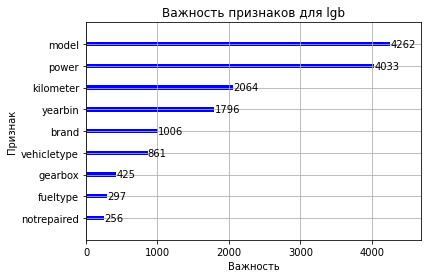

In [68]:
ax0 = lgb.plot_importance(gbm, color='b', title='Важность признаков для lgb', xlabel='Важность', ylabel='Признак')

**Вывод: Несколько противоречивый результат по сравненин с EDA в отношении признака 'model'. С остальными признаками болeе менее коррелирует.**

In [69]:
dff = df.copy()
_, cat_features_name = getlist(dff)

for col in cat_features_name:
    dff[col] = dff[col].astype('category')

In [70]:
dff.dtypes

price             int64
vehicletype    category
gearbox        category
power             int64
model          category
kilometer         int64
fueltype       category
brand          category
notrepaired    category
yearbin        category
dtype: object

In [71]:
XX = dff.drop(['price'], axis=1)
yy = dff['price'] 

XX_train, XX_valid, yy_train, yy_valid = train_test_split(XX, yy, test_size=0.25, random_state=12345)

In [72]:
starttime = time.time()
lgb_train = lgb.Dataset(XX_train, yy_train)
gbm = lgb.train(hyper_params, lgb_train, num_boost_round=10, verbose_eval=False, categorical_feature = cat_features_name)
trainingtime = time.time() - starttime

starttime = time.time()
y_predict = gbm.predict(XX_valid)
predicttime = time.time() - starttime

RMSE = np.sqrt(mean_squared_error(yy_valid, y_predict))

result_list.append({ 'model': 'LGBMRegressor +++ ','trainingtime':trainingtime, 'predicttime':predicttime, 'RMSE':RMSE})

print()
print(RMSE)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 210967, number of used features: 9
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 4778.280281

1661.627385604273


### CatBoost

https://catboost.ai/docs/search/?query=categorial

Categorical features
Categorical features. Do not use one-hot encoding during preprocessing. This affects both the training speed and the resulting quality. 

https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html#algorithm-main-stages_cat-to-numberic

Transforming categorical features to numerical features


In [73]:
# подготовим список индексов категориальных переменных для CatBoost
categorical_features_indices = [i for i, x in enumerate(X_train.columns) if x in cat_features_name] 
categorical_features_indices

[0, 1, 2, 3, 4, 5, 6]

In [74]:
%%time
model = CatBoostRegressor(iterations=50, max_depth=16, learning_rate=0.1, loss_function='RMSE')

with myclock:
    model.fit(X_train, y_train,cat_features = categorical_features_indices, \
                       eval_set = (X_valid, y_valid), plot=False, verbose = False)
trainingtime = myclock.runtime

with myclock:
    y_predict = model.predict(X_valid)
predicttime = myclock.runtime
 
RMSE = np.sqrt(mean_squared_error(y_valid, y_predict))

result_list.append({ 'model': 'CatBoostRegressor','trainingtime':trainingtime, 'predicttime':predicttime, 'RMSE':RMSE})

Wall time: 1min 23s


#### Важность признаков для CatBoost

Взято здесь:
https://stackoverflow.com/questions/64988694/how-can-i-get-the-feature-importance-of-a-catboost-in-a-pandas-dataframe

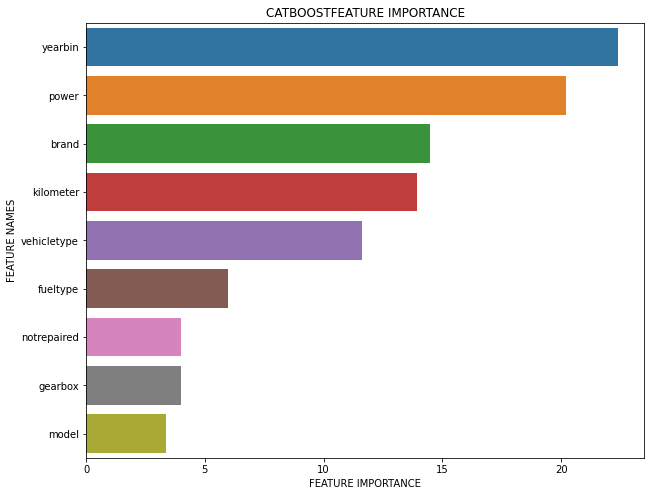

In [75]:
def plot_feature_importance(importance, names, model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values( by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    
#plot the catboost result
plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST')

**Вывод: Важность признаков для CatBoost неплохо коррелирует с EDA.**

## Анализ моделей

Посмотрим на результирующую табличку.

In [76]:
df_result = pd.DataFrame(result_list)
df_result.sort_values(by = 'RMSE')

,model,trainingtime,predicttime,RMSE
4,LGBMRegressor,8.856323,1.662902,1661.627386
5,LGBMRegressor +++,8.547626,1.707709,1661.627386
6,CatBoostRegressor,83.382060,0.306822,1774.374752
1,DecisionTreeRegressor,0.849462,0.043079,1949.825262
2,LinearRegression,0.069959,0.002184,2758.599228
3,Lassoalpha=0.1,0.127631,0.015622,2758.599493
0,DummyRegressor,0.001999,0.000000,4598.506288


**Вывод: Все модели дают адекватные предсказания. По совокупности показателей точность и скорость можно отдать предпочтение обычному дереву  DecisionTreeRegressor с гиперпараметрами по умолчанию.**

## Выводы

Были построены различные модели для оценки стоимости автомобиля. Затем была проверена адекватность моделей в сравнении с DummyRegressor.

Наиболее точной оказалась модель LGBMRegressor. При относительно приемлемой скорости обучения. Если же принебречь небольшой потерей точности, то можно предпочесть обычное дерево решений DecisionTreeRegressor, как весьма быструю модель.

CatBoostRegressor оказался в обучении самым медленным.

Линейные модели LinearRegression и Lasso оказались наименее наиемлимыми по точности.

Важность признаков распределилась следующим образом:

Наиболее важные признаки:
- RegistrationYear — год регистрации автомобиля
- Power — мощность (л. с.)
- Kilometer — пробег (км)
- Brand — марка автомобиля

Наименее важными оказались:
- Gearbox — тип коробки передач
- Model — модель автомобиля
- FuelType — тип топлива
- NotRepaired — была машина в ремонте или нет
